In [1]:
import numpy
import pandas
import torch
import tqdm

In [2]:
import matplotlib

In [3]:
import sys
sys.path.append('./')
from lstm.dataset import DenoiseDataModule
from lstm.controller import GAFS
import os
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas

~/miniconda3/envs/shaow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
import argparse
def gen_init(name):
	parser = argparse.ArgumentParser()
	parser.add_argument('--task_name', type=str, choices=['airfoil', 'amazon_employee',
	                                                      'ap_omentum_ovary', 'german_credit',
	                                                      'higgs', 'housing_boston', 'ionosphere',
	                                                      'lymphography', 'messidor_features', 'openml_620',
	                                                      'pima_indian', 'spam_base', 'spectf', 'svmguide3',
	                                                      'uci_credit_card', 'wine_red', 'wine_white', 'openml_586',
	                                                      'openml_589', 'openml_607', 'openml_616', 'openml_618',
	                                                      'openml_637'], default='lymphography')
	parser.add_argument('--mask_whole_op_p', type=float, default=0.0)
	parser.add_argument('--mask_op_p', type=float, default=0.0)
	parser.add_argument('--disorder_p', type=float, default=0.0)
	parser.add_argument('--num', type=int, default=0)

	parser.add_argument('--method_name', type=str, choices=['rnn'], default='rnn')

	parser.add_argument('--encoder_layers', type=int, default=1)
	parser.add_argument('--encoder_hidden_size', type=int, default=64)
	parser.add_argument('--encoder_emb_size', type=int, default=32)
	parser.add_argument('--mlp_layers', type=int, default=2)
	parser.add_argument('--mlp_hidden_size', type=int, default=200)
	parser.add_argument('--decoder_layers', type=int, default=1)
	parser.add_argument('--decoder_hidden_size', type=int, default=64)

	parser.add_argument('--encoder_dropout', type=float, default=0)
	parser.add_argument('--mlp_dropout', type=float, default=0)
	parser.add_argument('--decoder_dropout', type=float, default=0)

	parser.add_argument('--new_gen', type=int, default=200)

	parser.add_argument('--dropout', type=float, default=0.0)
	parser.add_argument('--batch_size', type=int, default=2048)
	parser.add_argument('--lr', type=float, default=0.001)
	parser.add_argument('--beta', type=float, default=0.95)
	parser.add_argument('--grad_bound', type=float, default=5.0)
	parser.add_argument('--l2_reg', type=float, default=0.0)
	parser.add_argument('--seed', type=int, default=1)
	parser.add_argument('--top_k', type=int, default=20)

	parser.add_argument('--load_epoch', type=int, default=2000)
	parser.add_argument('--train_top_k', type=int, default=512)
	parser.add_argument('--epochs', type=int, default=2000)
	parser.add_argument('--eval', type=bool, default=False)
	parser.add_argument('--max_step_size', type=int, default=5)

	parser.add_argument('--beams', type=int, default=5)
	parser.add_argument('--add_origin', type=bool, default=True)
	parser.add_argument('--add_transformed', type=bool, default=False)
	parser.add_argument('--gpu', type=int, default=0)

	parser.add_argument('--keyword', type=str, default='')

	return parser.parse_args(f"--task_name {name}".split())

In [6]:
def gen_data(name):
	args = gen_init(name)
	args.num = 0
	dm = DenoiseDataModule(args)
	fe = dm.fe
	model = GAFS(fe, args, dm.tokenizer)
	base_path = './data'
	maybe_load_from = os.path.join(f'{base_path}', 'history', f'{dm.fe.task_name}', f'model_dmp{args.keyword}',
	                                   f'{dm.fe.task_name}_{args.load_epoch}.encoder.pt')
	from utils.datacollection.logger import info
	device = int(args.gpu)
	if args.load_epoch > 0 and os.path.exists(maybe_load_from):
	    base_load_path = os.path.join(f'{base_path}', 'history')
	    start_epoch = args.load_epoch
	    model = model.from_pretrain(base_load_path, fe, args, dm.tokenizer, start_epoch, keyword=args.keyword)
	    model = model.cuda(device)
	else:
	    start_epoch = 0
	    model = model.cuda(device)
	train_queue = dm.train_dataloader()
	gather = []
	p = []
	import tqdm
	model.eval()
	for sample in tqdm.tqdm(train_queue):
		encoder_input = sample['encoder_input']
		encoder_target = sample['encoder_target']
		# decoder_target = sample['decoder_target']

		encoder_input = encoder_input.cuda(model.gpu)
		encoder_target = encoder_target.cuda(model.gpu)
		# decoder_target = decoder_target.cuda(model.gpu)
		p.append(encoder_target)
		encoder_outputs, encoder_hidden, seq_emb, predict_value = model.encoder.forward(encoder_input)
		gather.append((encoder_outputs, encoder_hidden, seq_emb))

	hidden = torch.cat([seq for _,_,seq in gather], 0)
	performance = torch.cat(p, 0)
	label = torch.zeros_like(performance)
	for i in range(50):
		percentage = 1 / (i + 1)
		top_p , top_indice = torch.topk(performance, int(performance.shape[0] * percentage), dim = 0)
		label[top_indice] = i + 1
	hidden_numpy = hidden.cpu().detach().numpy()
	tsne = TSNE(n_components=2)
	_2d_tsne_hidden = tsne.fit_transform(hidden_numpy, y = performance.cpu().numpy())
	pca = PCA(n_components=2)
	_2d_pca_hidden = pca.fit_transform(hidden_numpy, y = performance.cpu().numpy())
	plt.figure(figsize=(7, 5))
	plt.scatter(_2d_pca_hidden[:, 0], _2d_pca_hidden[:, 1], s=10, marker ='s' ,c=label.cpu().detach().numpy(), cmap=plt.cm.Reds)
	plt.show()
	plt.figure(figsize=(7, 5))
	plt.scatter(_2d_tsne_hidden[:, 0], _2d_tsne_hidden[:, 1], s=10, marker ='s' ,c=label.cpu().detach().numpy(), cmap=plt.cm.Reds)
	plt.show()
	print(name, 'done')
	tsne_ = pandas.concat([pandas.DataFrame(_2d_tsne_hidden), pandas.DataFrame(label.cpu())], 1)
	pca_ = pandas.concat([pandas.DataFrame(_2d_pca_hidden), pandas.DataFrame(label.cpu())], 1)
	return tsne_, pca_

INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/spectf/performance.list.True.pkl and ./data/history/spectf/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91650/91650 [00:00<00:00, 2775027.88it/s]
lengthy[0.95] processing: 91650it [00:00, 2191432.62it/s]


INFO:  selected length is 765.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.8591465725626023], the original_best is [0.8591465725626023]
INFO:  shit! for setting strategy as length with 0.95 is not suitable for task spectf
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 62230.03it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


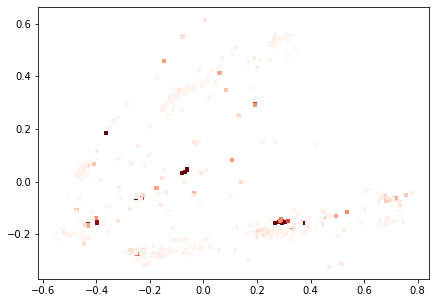

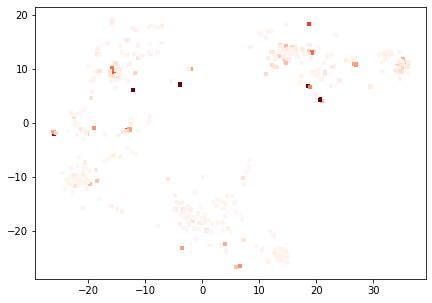

spectf done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/spam_base/performance.list.True.pkl and ./data/history/spam_base/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84525/84525 [00:00<00:00, 2802956.51it/s]
lengthy[0.95] processing: 84525it [00:00, 2170131.58it/s]


INFO:  selected length is 997.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.9551206714548833], the original_best is [0.9581676311888241]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33235.37it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.94s/it]


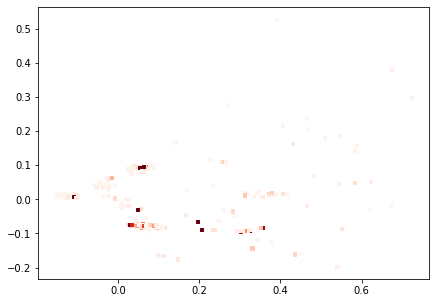

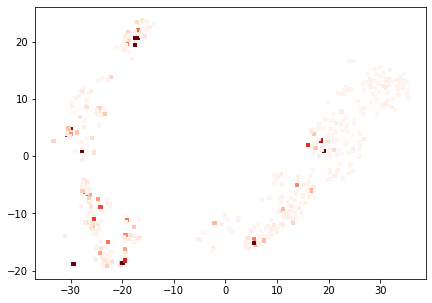

spam_base done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_616/performance.list.True.pkl and ./data/history/openml_616/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76950/76950 [00:00<00:00, 2832049.53it/s]
lengthy[0.95] processing: 76950it [00:00, 1989543.43it/s]


INFO:  selected length is 608.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7515277339460269], the original_best is [0.7544490723734651]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 51909.70it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.32s/it]


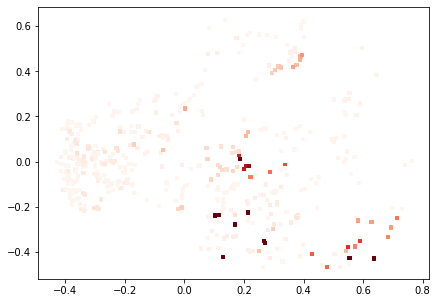

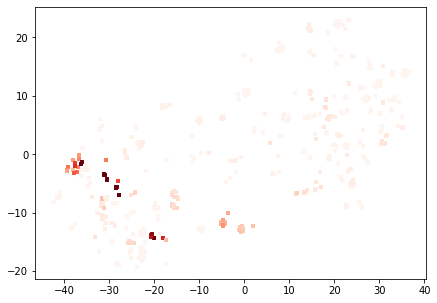

openml_616 done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_618/performance.list.True.pkl and ./data/history/openml_618/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77575/77575 [00:00<00:00, 2782964.97it/s]
lengthy[0.95] processing: 77575it [00:00, 2156574.20it/s]


INFO:  selected length is 742.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7975086599643022], the original_best is [0.7975086599643022]
INFO:  shit! for setting strategy as length with 0.95 is not suitable for task openml_618
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39383.14it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


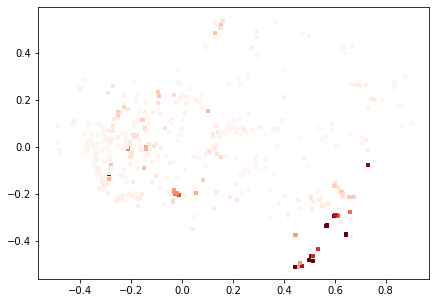

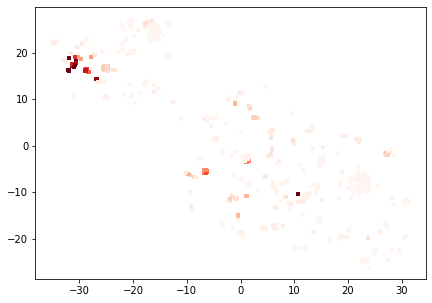

openml_618 done


In [26]:
ret = dict()
for name in ['spectf', 'spam_base', 'openml_616', 'openml_618']:
	a, b =  gen_data(name)
	a.to_csv(f'./data/distribution/{name}_tsne.csv',header=['x', 'y', 'size'])
	b.to_csv(f'./data/distribution/{name}_pca.csv',header=['x', 'y', 'size'])

INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/pima_indian/performance.list.True.pkl and ./data/history/pima_indian/operation.list.True.pkl


calculate the max length: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103625/103625 [00:00<00:00, 2921835.73it/s]
lengthy[0.95] processing: 103625it [00:00, 2094181.24it/s]


INFO:  selected length is 652.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7765319483767102], the original_best is [0.7822647800776719]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 63310.25it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.54s/it]


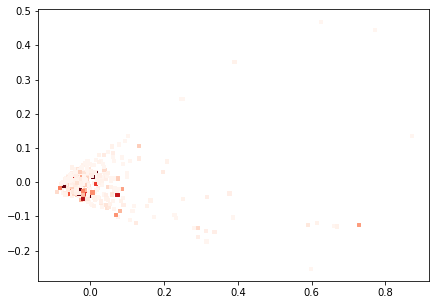

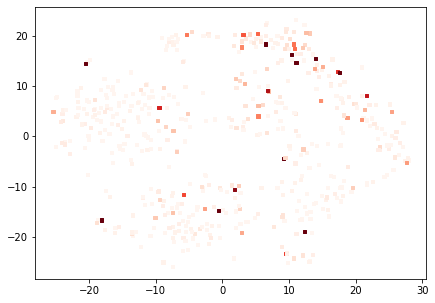

pima_indian done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/airfoil/performance.list.True.pkl and ./data/history/airfoil/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71200/71200 [00:00<00:00, 2569583.67it/s]
lengthy[0.95] processing: 71200it [00:00, 2079178.21it/s]


INFO:  selected length is 142.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7813808285983099], the original_best is [0.7850850811933727]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54436.13it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.14s/it]


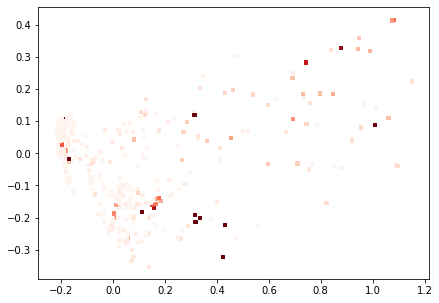

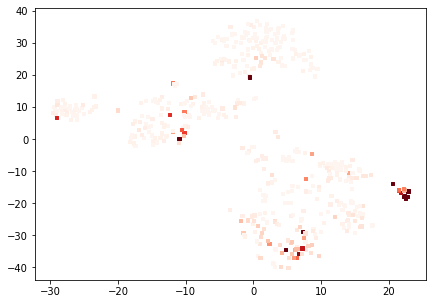

airfoil done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_586/performance.list.True.pkl and ./data/history/openml_586/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79800/79800 [00:00<00:00, 2875155.35it/s]
lengthy[0.95] processing: 79800it [00:00, 2079678.01it/s]


INFO:  selected length is 418.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.8035321288302925], the original_best is [0.8079710751665837]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27016.45it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.10s/it]


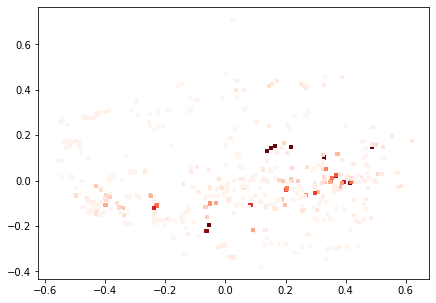

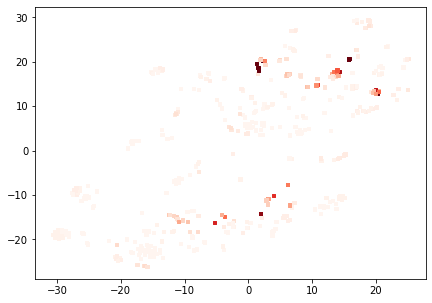

openml_586 done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/amazon_employee/performance.list.True.pkl and ./data/history/amazon_employee/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47400/47400 [00:00<00:00, 2920026.58it/s]
lengthy[0.95] processing: 47400it [00:00, 2151041.49it/s]


INFO:  selected length is 468.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.9456582655774716], the original_best is [0.9458866201327382]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21410.43it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.68s/it]


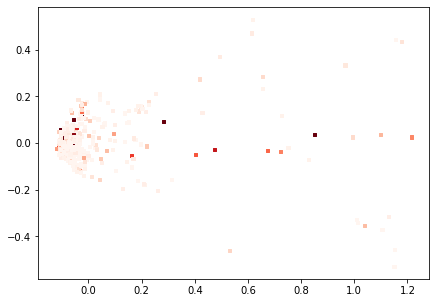

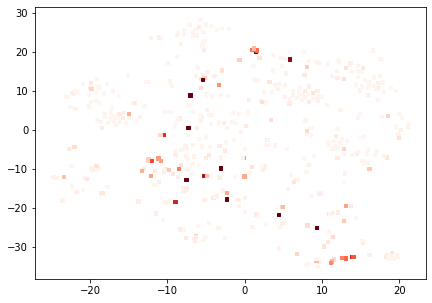

amazon_employee done


In [27]:
for name in ['pima_indian', 'airfoil', 'openml_586', 'amazon_employee']:
	a, b =  gen_data(name)
	a.to_csv(f'./data/distribution/{name}_tsne.csv',header=['x', 'y', 'size'])
	b.to_csv(f'./data/distribution/{name}_pca.csv',header=['x', 'y', 'size'])

INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/spectf/performance.list.True.pkl and ./data/history/spectf/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91650/91650 [00:00<00:00, 2794088.94it/s]
lengthy[0.95] processing: 91650it [00:00, 2222499.52it/s]


INFO:  selected length is 765.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.8591465725626023], the original_best is [0.8591465725626023]
INFO:  shit! for setting strategy as length with 0.95 is not suitable for task spectf
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28571.55it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.79s/it]


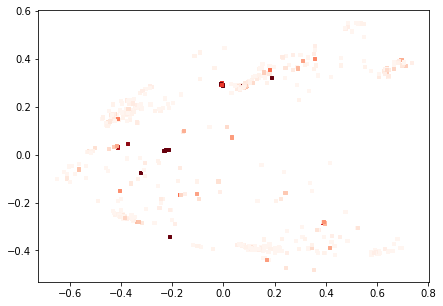

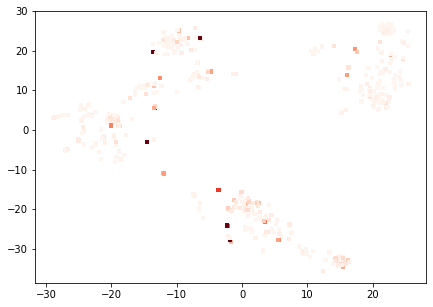

spectf done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/spam_base/performance.list.True.pkl and ./data/history/spam_base/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84525/84525 [00:00<00:00, 2866226.42it/s]
lengthy[0.95] processing: 84525it [00:00, 2126333.27it/s]


INFO:  selected length is 997.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.9551206714548833], the original_best is [0.9581676311888241]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36173.39it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]


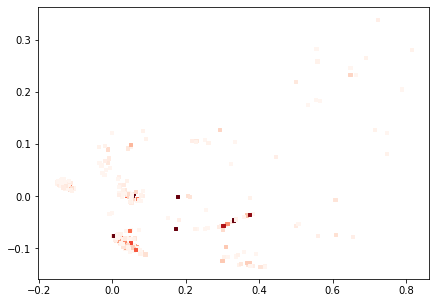

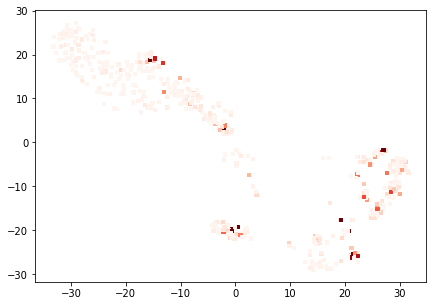

spam_base done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_616/performance.list.True.pkl and ./data/history/openml_616/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76950/76950 [00:00<00:00, 2790521.29it/s]
lengthy[0.95] processing: 76950it [00:00, 2115225.56it/s]


INFO:  selected length is 608.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7515277339460269], the original_best is [0.7544490723734651]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38182.10it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.99s/it]


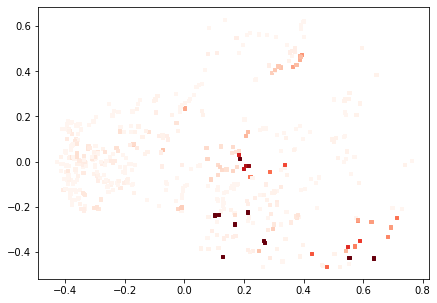

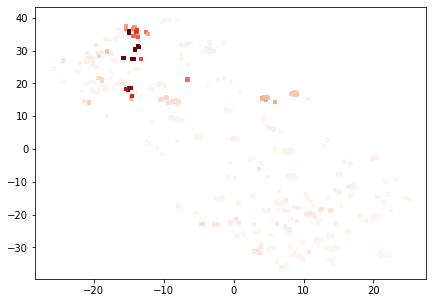

openml_616 done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_618/performance.list.True.pkl and ./data/history/openml_618/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77575/77575 [00:00<00:00, 2745185.68it/s]
lengthy[0.95] processing: 77575it [00:00, 2010039.49it/s]


INFO:  selected length is 742.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7975086599643022], the original_best is [0.7975086599643022]
INFO:  shit! for setting strategy as length with 0.95 is not suitable for task openml_618
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28679.00it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


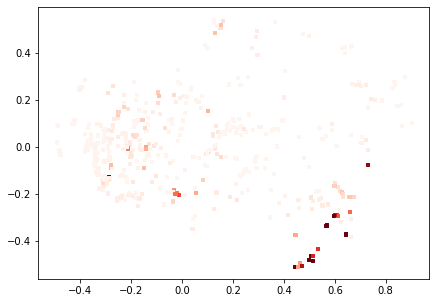

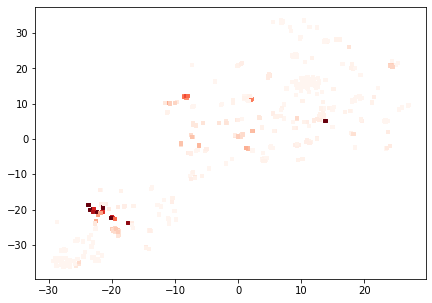

openml_618 done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/pima_indian/performance.list.True.pkl and ./data/history/pima_indian/operation.list.True.pkl


calculate the max length: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103625/103625 [00:00<00:00, 2941849.66it/s]
lengthy[0.95] processing: 103625it [00:00, 2095311.97it/s]


INFO:  selected length is 652.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7765319483767102], the original_best is [0.7822647800776719]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 48182.70it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.28s/it]


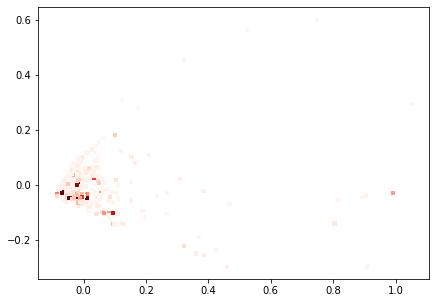

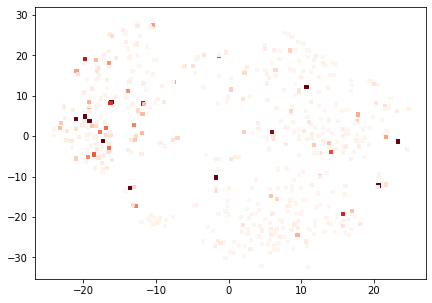

pima_indian done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/airfoil/performance.list.True.pkl and ./data/history/airfoil/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71200/71200 [00:00<00:00, 2881542.74it/s]
lengthy[0.95] processing: 71200it [00:00, 1959299.33it/s]


INFO:  selected length is 142.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.7813808285983099], the original_best is [0.7850850811933727]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 47743.93it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


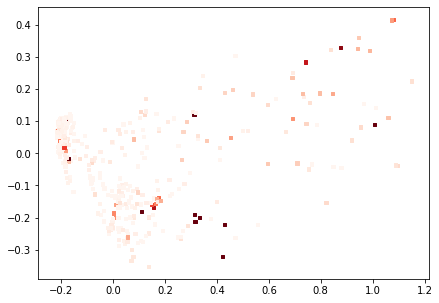

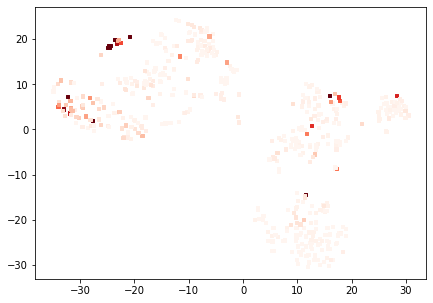

airfoil done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/openml_586/performance.list.True.pkl and ./data/history/openml_586/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79800/79800 [00:00<00:00, 2804026.77it/s]
lengthy[0.95] processing: 79800it [00:00, 2066542.31it/s]


INFO:  selected length is 418.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.8035321288302925], the original_best is [0.8079710751665837]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 69499.65it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.69s/it]


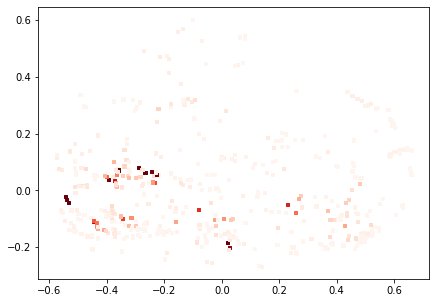

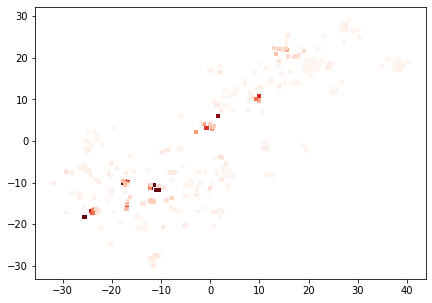

openml_586 done
INFO:  initialize the train and test dataset
INFO:  have processed the data, load cache from local in :./data/history/amazon_employee/performance.list.True.pkl and ./data/history/amazon_employee/operation.list.True.pkl


calculate the max length: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47400/47400 [00:00<00:00, 2839656.20it/s]
lengthy[0.95] processing: 47400it [00:00, 1981363.46it/s]


INFO:  selected length is 468.0
INFO:  using lengthy to remove outlier
INFO:  the best removed is [0.9456582655774716], the original_best is [0.9458866201327382]
INFO:  load records from disk...


denoise data gen: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 64035.18it/s]


INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...
INFO:  Construct Encoder with method rnn...
INFO:  Construct Decoder with method rnn...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


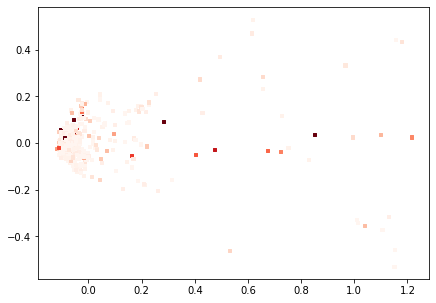

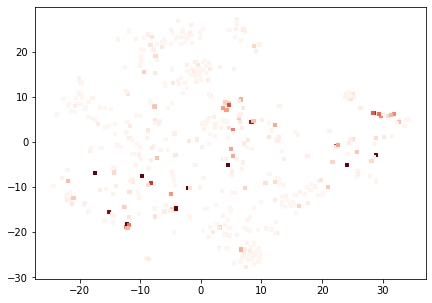

amazon_employee done


In [7]:
ret_tsne = dict()
ret_pca = dict()
for name in ['spectf', 'spam_base', 'openml_616', 'openml_618', 'pima_indian', 'airfoil', 'openml_586', 'amazon_employee']:
	a, b = gen_data(name)
	ret_tsne[name] = a
	ret_pca[name] = b

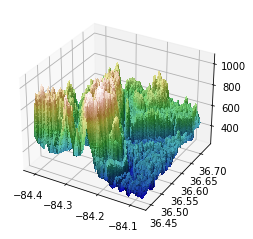

In [60]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

# Load and format data
dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
z = dem['elevation']
nrows, ncols = z.shape
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]
z = density
# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [14]:
z.shape

(45, 45)

In [53]:
import numpy
density = numpy.zeros((45, 45), int)
data = ret_tsne['spectf']
# for x,y,z in ret_tsne['spectf']:
# 	for x,y,z in ret_tsne['spectf']:


In [17]:
dem['elevation'].shape

(344, 403)

In [8]:
# %matplotlib qt
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [21]:

def regions(x, y, min_x, min_y, share_x, share_y):
	return int((x - min_x) / share_x) - 1, int((y - min_y) / share_y) - 1

In [37]:

def trans(name, method):
	path = f'./lstm/exp/distibution/{name}_{method}.csv'
	data = pandas.read_csv(path)
	max_x = np.max(data.iloc[:,1])
	min_x = np.min(data.iloc[:,1])
	max_y = np.max(data.iloc[:,2])
	min_y = np.min(data.iloc[:,2])
	share_x = (max_x - min_x) / 45
	share_y = (max_y - min_y) / 45
	density = np.zeros((45,45))
	for x_in in range(int(45)):
		for y_in in range(int(45)):
			for i in range(data.shape[0]):
				# print(data.iloc[i, :])
				_, x, y, z = data.iloc[i, :]
				r_x, r_y = regions(x, y, min_x, min_y, share_x, share_y)
				dist = ((r_x - x_in) ** 2 + (r_y - y_in) ** 2)**(1/2)
				if dist < np.log(z) and dist != 0:
					density[x_in, y_in] += (np.log(z) - np.log(dist) + 1)
				if dist == 0:
					density[x_in, y_in] += (np.log(z)  + 1)
	for x_in in range(int(45)):
		for y_in in range(int(45)):
			if np.isinf(density[x_in, y_in]):
				indices = []
				for a, b in [[x_in + 1, y_in], [x_in, y_in+ 1], [x_in-1, y_in], [x_in, y_in-1], [x_in + 1, y_in + 1], [x_in + 1, y_in - 1], [x_in - 1, y_in - 1], [x_in - 1, y_in + 1]]:
					if a < 45 and a  >= 0 and b < 45 and b >= 0 and not np.isinf(density[a, b]):
						indices.append([a,b])
				density[x_in, y_in] = np.nanmean([density[a, b] for a, b in indices])
	# Load and format data
	dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
	z = dem['elevation']
	nrows, ncols = z.shape
	x = np.linspace(dem['xmin'], dem['xmax'], ncols)
	y = np.linspace(dem['ymin'], dem['ymax'], nrows)
	x, y = np.meshgrid(x, y)

	region = np.s_[5:50, 5:50]
	x, y, z = x[region], y[region], z[region]
	z = density
	# Set up plot
	fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), dpi=400)
	ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='RdYlGn_r', linewidth=0, antialiased=False, shade=False)

	    # Update the axis view and title

	ax.xaxis.pane.fill = False
	ax.yaxis.pane.fill = False
	ax.zaxis.pane.fill = False
	# ax.xaxis.pane.set_edgecolor('w')
	# ax.yaxis.pane.set_edgecolor('w')
	# ax.zaxis.pane.set_edgecolor('w')
	# ax._axis3don = False
	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.set_zticklabels([])
	ax.contour(x,y,z,offset=-2, cmap = 'rainbow')
	# ax.grid(False)
	for angle in range(0, 360):
		ax.view_init(30, angle)
		plt.show()
	# plt.savefig(f'./lstm/exp/distibution/figure/{name}_{method}.png', transparent=True)
	density.reshape(-1, 1)
	return density

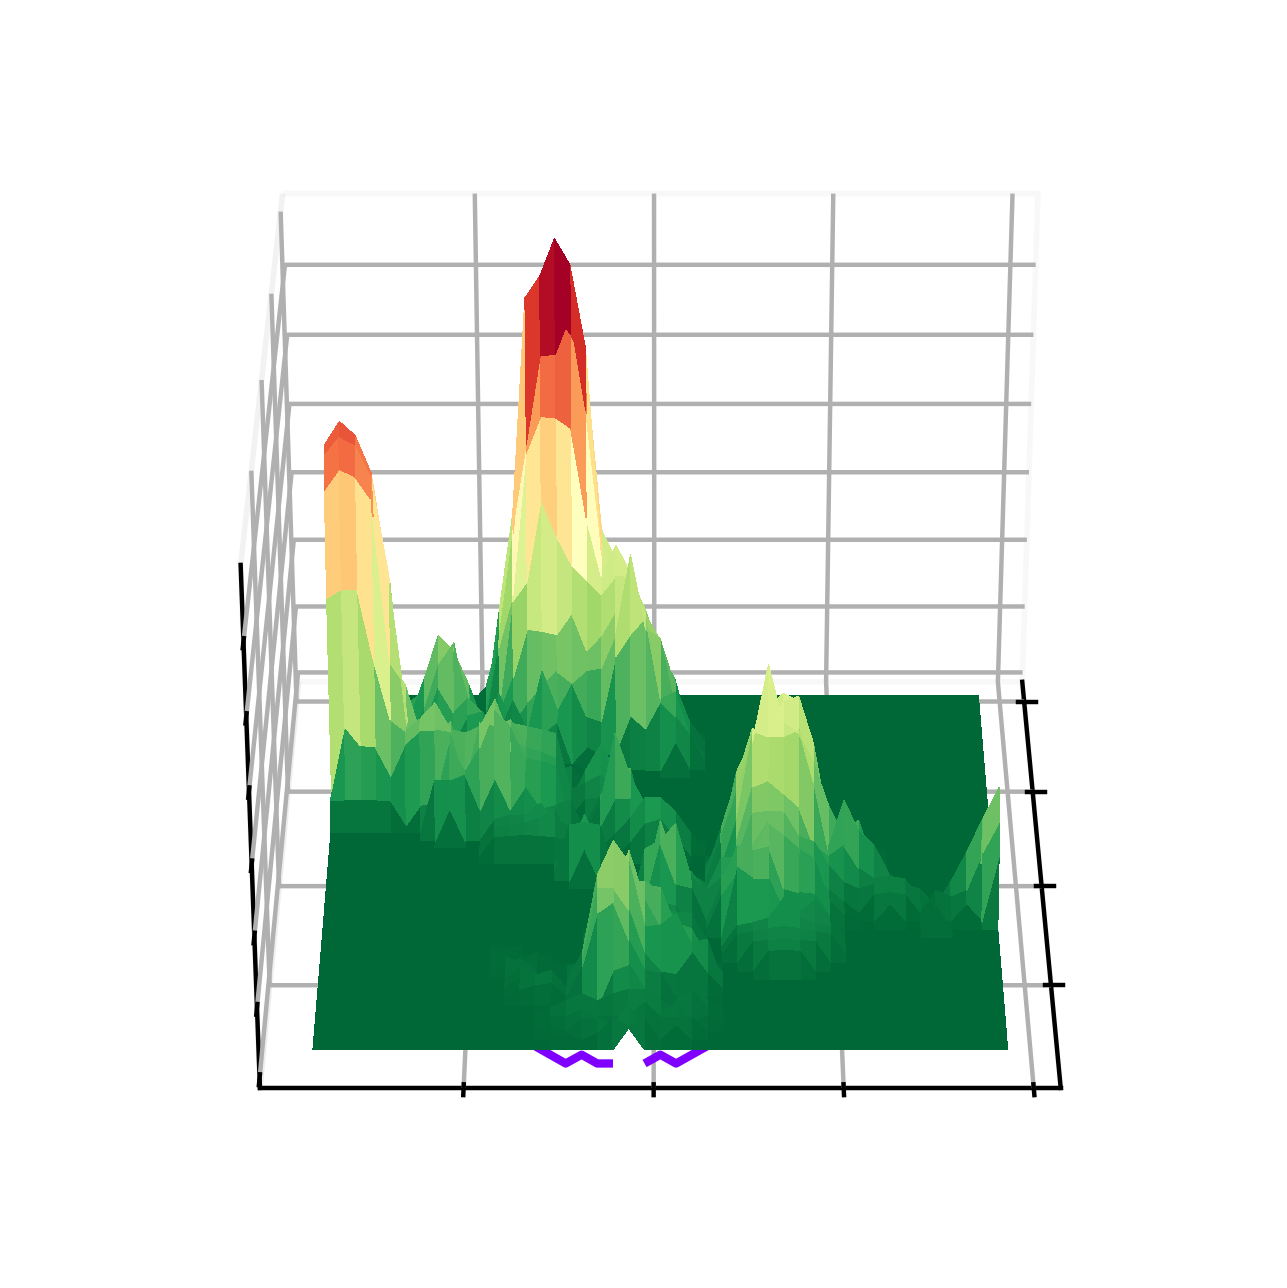

In [38]:
a = trans('airfoil', 'tsne')

In [130]:
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)

In [133]:
name = 'airfoil'
method = 'tsne'
path = f'./lstm/exp/distibution/{name}_{method}.csv'
data = pandas.read_csv(path)

In [134]:
x, y, z = data.iloc[:, 1], data.iloc[:, 2], data.iloc[:, 3]

In [138]:
x, y = np.meshgrid(x,y)
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='RdYlGn_r', linewidth=0, antialiased=False, shade=False)

	    # Update the axis view and title
ax.view_init(20, 30, 0)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')
# ax._axis3don = False
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.grid(False)
plt.draw()

KeyboardInterrupt: 

In [40]:
pandas.DataFrame(a.reshape(-1,1)).to_csv('./lstm/exp/distibution/test.csv', header=None)